In [292]:
from manifold_learning.data.data_loader import load_csv_dataset
from manifold_learning import IMD
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
importlib.reload(IMD)

<module 'manifold_learning.IMD' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/IMD.py'>

In [293]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]

In [294]:
trainer = IMD.IMD_nD(X.shape[1], embed_dim=5, n_components=3,learning_rate=0.001, device="cuda",optimizer="Adam",random_state=2)

In [295]:
trainer.fit(X, sample_len=300, library_len=800, nbrs_num=15, tp=60, epochs=1000, num_batches=32)


Epoch 1/1000, Loss: 1.0169
Epoch 2/1000, Loss: 0.9940
Epoch 3/1000, Loss: 0.9746
Epoch 4/1000, Loss: 0.9466
Epoch 5/1000, Loss: 0.9204
Epoch 6/1000, Loss: 0.9067
Epoch 7/1000, Loss: 0.8865
Epoch 8/1000, Loss: 0.8761
Epoch 9/1000, Loss: 0.8694
Epoch 10/1000, Loss: 0.8485
Epoch 11/1000, Loss: 0.8424
Epoch 12/1000, Loss: 0.8358
Epoch 13/1000, Loss: 0.8218
Epoch 14/1000, Loss: 0.8126
Epoch 15/1000, Loss: 0.7994
Epoch 16/1000, Loss: 0.7991
Epoch 17/1000, Loss: 0.7978
Epoch 18/1000, Loss: 0.7799
Epoch 19/1000, Loss: 0.7702
Epoch 20/1000, Loss: 0.7705


KeyboardInterrupt: 

In [141]:
from mpl_toolkits.mplot3d import Axes3D
import os
import imageio

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

for i in range(1000):
    trainer.fit(X, sample_len=300, library_len=800, nbrs_num=15, tp=60, epochs=1, num_batches=32)

    ax = plt.figure(figsize=(5, 5),dpi=200).add_subplot(projection='3d')
    ax.plot(*trainer.predict(X)[:, 0].T, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")

    plt.savefig(f"{output_dir}/frame_{i:02d}.png")
    plt.close()

#with imageio.get_writer('animation.gif', mode='I', duration=0.25) as writer:
with imageio.get_writer('animation_adam.mp4', mode='I') as writer:
    for i in range(1000):
        filename = f"{output_dir}/frame_{i:02d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)


RuntimeError: cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned

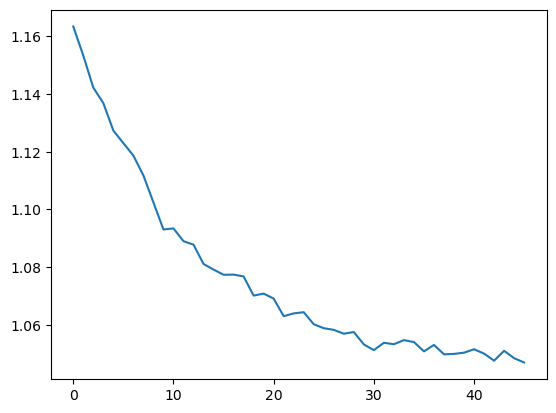

In [240]:
plt.plot(trainer.get_loss_history()[:400])

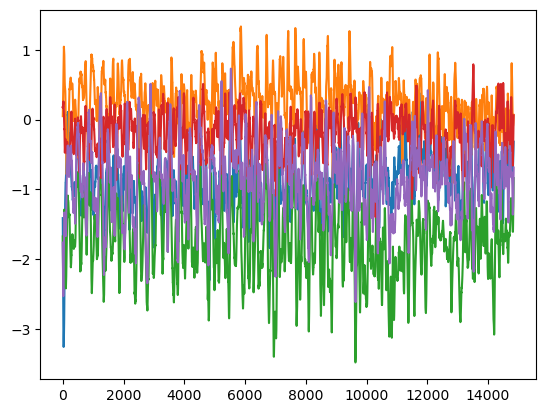

In [241]:
plt.plot(trainer.predict(X)[:,0,0])
plt.plot(trainer.predict(X)[:,0,1])
plt.plot(trainer.predict(X)[:,0,2])
plt.plot(trainer.predict(X)[:,0,3])
plt.plot(trainer.predict(X)[:,0,4])

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import os
import imageio
import matplotlib.pyplot as plt

# Assuming trainer is defined and has the 'fit' and 'predict' methods
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Generate and save frames for the single figure with 4 subplots
for i in range(1000):
    trainer.fit(X, sample_len=200, library_len=700, nbrs_num=15, tp=50, epochs=1, num_batches=32)
    xx = trainer.predict(X)

    fig, axs = plt.subplots(2, 2, figsize=(15, 15), subplot_kw={'projection': '3d'})
    titles = ["Chart 1", "Chart 2", "Chart 3", "Chart 4"]

    for j, ax in enumerate(axs.flat):
        ax.plot(*xx[:, j].T, lw=0.5)
        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        ax.set_zlabel("Z Axis")
        ax.set_title(titles[j])

    plt.savefig(f"{output_dir}/frame_{i:02d}.png")
    plt.close(fig)

# Create a video file from the saved frames
with imageio.get_writer('animation_4_charts3.mp4', mode='I') as writer:
    for i in range(1000):
        filename = f"{output_dir}/frame_{i:02d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)


Epoch 1/1, Loss: 0.9201
Epoch 1/1, Loss: 0.8910
Epoch 1/1, Loss: 0.8486
Epoch 1/1, Loss: 0.8315
Epoch 1/1, Loss: 0.8091
Epoch 1/1, Loss: 0.7960
Epoch 1/1, Loss: 0.7813
Epoch 1/1, Loss: 0.7602
Epoch 1/1, Loss: 0.7542
Epoch 1/1, Loss: 0.7486
Epoch 1/1, Loss: 0.7313
Epoch 1/1, Loss: 0.7243
Epoch 1/1, Loss: 0.7147
Epoch 1/1, Loss: 0.7170
Epoch 1/1, Loss: 0.7113
Epoch 1/1, Loss: 0.6992
Epoch 1/1, Loss: 0.6986
Epoch 1/1, Loss: 0.6911
Epoch 1/1, Loss: 0.6872
Epoch 1/1, Loss: 0.6900
Epoch 1/1, Loss: 0.6821
Epoch 1/1, Loss: 0.6833
Epoch 1/1, Loss: 0.6801
Epoch 1/1, Loss: 0.6660
Epoch 1/1, Loss: 0.6627
Epoch 1/1, Loss: 0.6667
Epoch 1/1, Loss: 0.6630
Epoch 1/1, Loss: 0.6566
Epoch 1/1, Loss: 0.6580
Epoch 1/1, Loss: 0.6481
Epoch 1/1, Loss: 0.6525
Epoch 1/1, Loss: 0.6503
Epoch 1/1, Loss: 0.6454
Epoch 1/1, Loss: 0.6415
Epoch 1/1, Loss: 0.6417
Epoch 1/1, Loss: 0.6402
Epoch 1/1, Loss: 0.6281
Epoch 1/1, Loss: 0.6242
Epoch 1/1, Loss: 0.6242
Epoch 1/1, Loss: 0.6176
Epoch 1/1, Loss: 0.6242
Epoch 1/1, Loss:

/tmp/ipykernel_5918/2952569846.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1500) to (1504, 1504) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
